C:\Users\ldelaigue\AppData\Local\Temp\ipykernel_15272\1459159164.py:27: RuntimeWarning: invalid value encountered in divide
  relative_uncertainty_1 = (uncertainty_data_1 / np.abs(dic_nat_total_change_data)) * 100
C:\Users\ldelaigue\AppData\Local\Temp\ipykernel_15272\1459159164.py:30: RuntimeWarning: invalid value encountered in divide
  relative_uncertainty_2 = (uncertainty_data_2 / np.abs(net_DIC_sequestration_data)) * 100


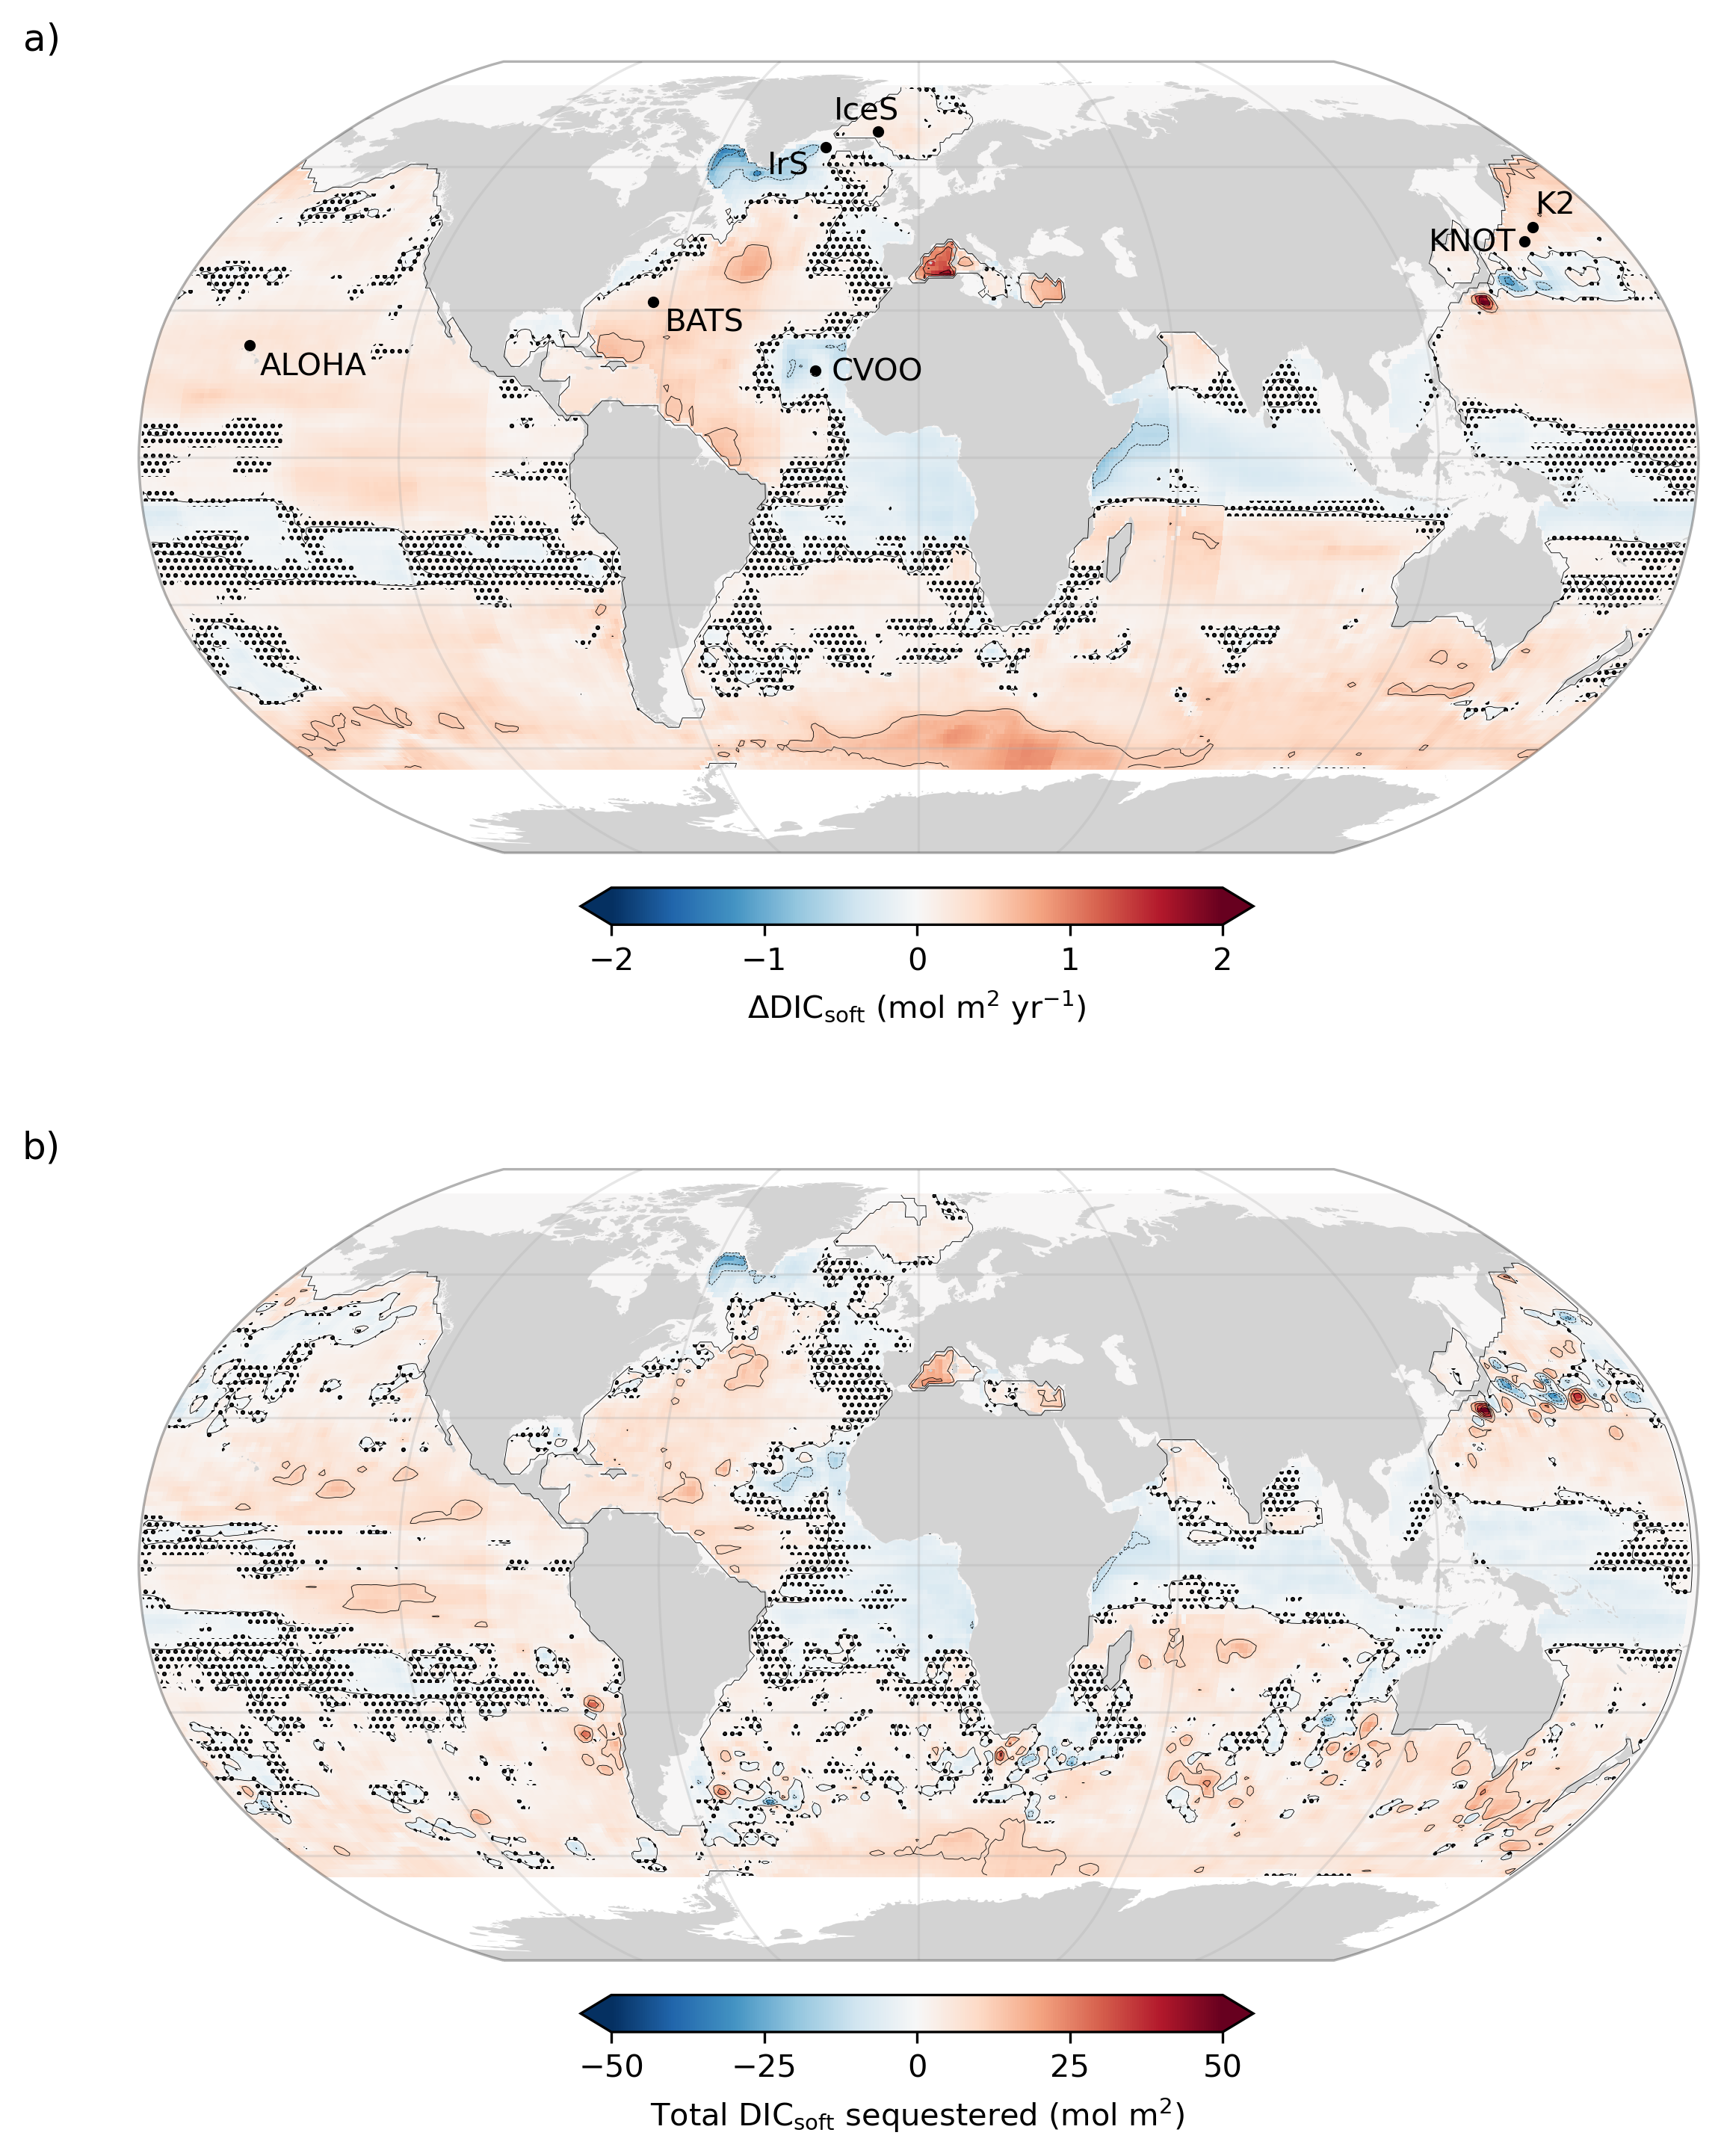

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm

# Load datasets
dic_nat_total_change = xr.open_dataset('data/02_DIC_integrated_change_map_monte_carlo_online_pres_diff.nc')
net_DIC_sequestration = xr.load_dataset('data/03_DIC_sequestration_below_winter_MLD_monte_carlo_online_1000_iterations.nc')

# Extract coordinates (lat, lon)
lon = dic_nat_total_change.coords['lon'].values
lat = dic_nat_total_change.coords['lat'].values
lon_2d, lat_2d = np.meshgrid(lon, lat)

# Extract data
dic_nat_total_change_data = dic_nat_total_change["soft_pump_aou_change"].values
net_DIC_sequestration_data = net_DIC_sequestration["DIC_nat_sequestration"].values

# Extract uncertainty data
uncertainty_data_1 = dic_nat_total_change["soft_pump_aou_change_uncertainty"].values
uncertainty_data_2 = net_DIC_sequestration["DIC_nat_sequestration_uncertainty"].values

# Compute relative uncertainty (%)
relative_uncertainty_1 = (uncertainty_data_1 / np.abs(dic_nat_total_change_data)) * 100
relative_uncertainty_1[np.isnan(relative_uncertainty_1)] = 0  # Handle division by zero cases

relative_uncertainty_2 = (uncertainty_data_2 / np.abs(net_DIC_sequestration_data)) * 100
relative_uncertainty_2[np.isnan(relative_uncertainty_2)] = 0

# Define high uncertainty threshold (90th percentile)
threshold_1 = np.percentile(relative_uncertainty_1, 90)
high_uncertainty_mask_1 = relative_uncertainty_1 > threshold_1  # Boolean mask

threshold_2 = np.percentile(relative_uncertainty_2, 90)
high_uncertainty_mask_2 = relative_uncertainty_2 > threshold_2  # Boolean mask

# Create figure
fig = plt.figure(figsize=(15, 11), dpi=300)

# --- First subplot: dic_nat_total_change ---
ax1 = fig.add_subplot(2, 1, 1, projection=ccrs.Robinson())
ax1.set_global()

# Add land feature
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='lightgrey')
ax1.add_feature(land_feature)

# Add gridlines
ax1.gridlines(draw_labels=False, alpha=0.3)

# Add subplot label
ax1.text(-0.05, 1.05, 'a)', transform=ax1.transAxes, fontsize=12, va='top', ha='right')

# Plot Î”DICnat data
norm1 = TwoSlopeNorm(vcenter=0, vmin=-2, vmax=2)
im1 = ax1.pcolormesh(lon_2d, lat_2d, dic_nat_total_change_data, transform=ccrs.PlateCarree(), cmap='RdBu_r', norm=norm1)

# Add uncertainty hatching
ax1.contourf(lon_2d, lat_2d, high_uncertainty_mask_1, levels=[0.5, 1], colors='xkcd:pale grey', hatches=['.....'], alpha=0.001, transform=ccrs.PlateCarree())

# Add contour lines
levels = np.arange(-2, 2, 0.5)
ax1.contour(lon_2d, lat_2d, dic_nat_total_change_data, levels=levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())

# Add colorbar
cbar_ax1 = fig.add_axes([0.412, 0.53, 0.2, 0.015])
cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal', extend='both')
cbar1.set_label(r'$\Delta$DIC$_{\mathrm{soft}}$ (mol m$^{2}$ yr$^{-1}$)')

# Add time series locations
time_series_locations = [
    (-158.002237, 22.752951, 'ALOHA', 4, -6),
    (-64.189528, 31.665369, 'BATS', 4, -6),
    (-24.278775, 17.594396, 'CVOO', 4, -2),
    (-12.670897, 67.996233, 'IceS', -15, 3),
    (-27.955002, 64.335978, 'IrS', -15, -6),
    (160.050667, 46.968458, 'K2', 4, 3),
    (154.998005, 44.003165, 'KNOT', -26, -2)
]

for x, y, label, x_offset, y_offset in time_series_locations:
    ax1.text(x + x_offset, y + y_offset, label, transform=ccrs.Geodetic(), fontsize=10)
    ax1.scatter(x, y, edgecolor='black', facecolor='black', linewidths=0.5, transform=ccrs.PlateCarree(), s=10)

# Adjust the transparency of the frame around the first plot
for spine in ax1.spines.values():
    spine.set_alpha(0.3)
    
# --- Second subplot: net_DIC_sequestration ---
ax2 = fig.add_subplot(2, 1, 2, projection=ccrs.Robinson())
ax2.set_global()

# Add land features
ax2.add_feature(land_feature)

# Add gridlines
ax2.gridlines(draw_labels=False, alpha=0.3)

# Add subplot label
ax2.text(-0.05, 1.05, 'b)', transform=ax2.transAxes, fontsize=12, va='top', ha='right')

# Plot data
norm2 = mcolors.TwoSlopeNorm(vmin=-50, vcenter=0, vmax=50)
im2 = ax2.pcolormesh(lon_2d, lat_2d, net_DIC_sequestration_data, transform=ccrs.PlateCarree(), cmap='RdBu_r', norm=norm2)

# Add uncertainty hatching
ax2.contourf(lon_2d, lat_2d, high_uncertainty_mask_2, levels=[0.5, 1], colors='xkcd:pale grey', hatches=['.....'], alpha=0.001, transform=ccrs.PlateCarree())

# Add contour lines
levels = np.arange(-50, 50, 10)
ax2.contour(lon_2d, lat_2d, net_DIC_sequestration_data, levels=levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())

# Add colorbar
cbar_ax2 = fig.add_axes([0.412, 0.081, 0.2, 0.015])
cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal', extend='both')
cbar2.set_label(r'Total DIC$_{\mathrm{soft}}$ sequestered (mol m$^{2}$)')
cbar2.set_ticks([50, 25, 0, -25, -50])

# Adjust the transparency of the frame around the second plot
for spine in ax2.spines.values():
    spine.set_alpha(0.3)

# Adjust layout
plt.subplots_adjust(hspace=0.4)

# Save figure
# fig.savefig('figs/Figure2_with_uncertainty.png', bbox_inches='tight', dpi=300)
plt.show()